In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import torch, os, random, copy
from torch.nn.utils import clip_grad_norm_
# from graph_aug import mask_nodes, mask_edges
from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from torch_ema import ExponentialMovingAverage
from ogb.utils import smiles2graph
from dualgraph.mol import smiles2graphwithface, smiles2graphwithface_with_mask
from dualgraph.gnn import GNN2
from torch_geometric.data import InMemoryDataset
from dualgraph.dataset import DGData
from torch_geometric.loader import DataLoader

from ogb.utils.features import (
    allowable_features,
    atom_to_feature_vector
)

from rdkit import Chem
import numpy as np
# from dualgraph.graph import getface

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

seed_everything(2024)

device = 'cuda'

In [6]:
class CustomDataset(InMemoryDataset):
    def __init__(self, root='dataset_path', transform=None, pre_transform=None, df=None, target_type='pretrain', mode='train'):
        self.df = df
        self.target_type = target_type
        super().__init__(root, transform, pre_transform, df)

    @property
    def raw_file_names(self):
        return [f'raw_{i+1}.pt' for i in range(self.df.shape[0])]

    @property
    def processed_file_names(self):
        return [f'data_{i+1}.pt' for i in range(self.df.shape[0])]

    def len(self):
        return self.df.shape[0]

    def get(self, idx):
        graph = self.graph_list[idx]
        mask_graph1 = mask_edges(mask_nodes(copy.deepcopy(graph), 0.3), 0.15)
        mask_graph2 = mask_edges(mask_nodes(copy.deepcopy(graph), 0.15), 0.3)

        return (graph, mask_graph1, mask_graph2)

    def process(self):
        smiles_list = self.df['smiles'].values
        data_list = []
        for i in range(len(smiles_list)):
            data = DGDate() # 분자형태의 데이터를 담기위한 빈 공간 느낌
            smiles = smiles_list[i]
            graph = smiles2graphwithface(smiles)

            data.__num_nodes__ = int(graph['num_nodes'])
            data.edge_index = torch.from_numpy(graph['edge_index']).to(torch.int64)
            data.edge_attr = torch.from_numpy(graph['edge_feat']).to(torch.int64)
            data.x = torch.from_numpy(graph['node_feat']).to(torch.int64)

            data.ring_mask = torch.from_numpy(graph['ring_mask']).to(torch.bool)
            data.ring_index = torch.from_numpy(graph['ring_index']).to(torch.int64)
            data.nf_node = torch.from_numpy(graph['nf_node']).to(torch.int64)
            data.nf_ring = torch.from_numpy(graph['nf_ring']).to(torch.int64)
            data.n_edges = int(graph['n_edges'])
            data.n_nodes = int(graph['n_nodes'])
            data.n_nfs = int(graph['n_nfs'])

            data_list.append(data)
        self.smiles_list = smiles_list
        self.graph_list = data_list


### Graph Augmentation

- 분자 화합물의 결합을 끊거나, 원자를 drop시킴
- 데이터셋에서 데이터를 가져오는 동시에 랜덤으로 원자와 결합을 drop시킴

In [7]:
def get(self, idx):
    graph = self.graph_list[idx]
    mask_graph1 = mask_edges(mask_nodes(copy.deepcopy(graph), 0.3), 0.15)
    mask_graph2 = mask_edges(mask_nodes(copy.deepcopy(graph), 0.15), 0.3)

    return (graph, mask_graph1, mask_graph2)

### Graph Contrastive Learning
- 모델이 원래 분자 구조를 복원하도록 self-supervised learning하는 학습 기법
- Label이 없어도 대량의 분자 구조를 학습하여 모델이 분자의 이해도를 높임
- BERT, GPT등이 학습하는 기법을 그래프 구조에 적용하는 방법

### Graph Contrastive Learning에 사용할 Loss
- Graph Augmentation을 적용시킨 분자 2개와 원본 분자를 동일하게 예측하도록 학습
- TripletMarginLoss : 3개의 벡터간의 거리를 계산하여 Loss값으로 사용함
- Contrastive Estimation Loss(loss_cl) : 2개의 변형한 분자 구조도 결국 비슷한 분자이므로 같아지게 학습함
- 총 2가지의 Loss를 사용

In [9]:
triplet_loss = nn.TripletMarginLoss(margin=0.1, p=2)

In [10]:
def loss_cl(x1, x2):
    T = 0.1
    batch_size, _ = x1.size()
    x1_abs = x1.norm(dim=1)
    x2_abs = x2.norm(dim=1)

    sim_matrix = torch.einsum('ik,jk->ij', x1, x2) / torch.einsum('i,j->ij', x1_abs, x2_abs)
    sim_matrix = torch.exp(sim_matrix / T)
    pos_sim = sim_matrix[range(batch_size), range(batch_size)]
    loss = pos_sim / (sim_matrix.sum(dim=1) - pos_sim)
    loss = - torch.log(loss).mean()
    return loss

### Model
- GNN : Graph Neural Network
- 그래프 구조 데이터를 처리하기 위한 딥러닝 모델
- GNN은 그래프의 노드, 엣지 사이의 관계를 학습하여 노드의 특징과 그래프 구조를 반영한 feature vector를 생성함

In [11]:
class MedModel(torch.nn.Module):
    def __init__(self):
        super(MedModel, self).__init__()
        self.ddi = True

        ### GNN을 통해 분자의 원자와 결합 정보를 활용하여 Feature Vector를 얻을 수 있음 ###
        self.gnn = GNN2(
            mlp_hidden_size = 512,
            mlp_layer = 4,
            latent_size = 128,
            use_layer_norm = False,
            use_face = True,
            # residual = True,
            ddi = self.ddi,
            dropedge_rate = 0.1,
            dropnode_rate = 0.1,
            dropout = 0.1,
            dropnet = 0.1,
            global_reducer = 'sum',
            node_reducer = 'sum',
            face_reducer = 'sum',
            global_pooling = 'sum',
            # global_attn = True,
            node_attn = True,
            face_attn = True,
            # use_bn = True,
        )

        ### Feature Vector의 표현력을 얻기위한 projection ###
        self.proj = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )

    def forward(self, batch):
        mol = self.gnn(batch).squeeze(1)
        return self.proj(mol)


### GNN 함수 뜯어보기

In [14]:
data = pd.read_csv('./pretrain/esol.csv')
data['dataset'] = 'esol'
data = data[['Compound ID', 'smiles', 'dataset']]
data.columns = ['sid', 'smiles', 'dataset']
data.head()

,sid,smiles,dataset
0,citral,CC(C)=CCCC(C)=CC(=O),esol
1,1-Pentene,CCCC=C,esol
2,Tetradecane,CCCCCCCCCCCCCC,esol
3,2-Chloropropane,CC(C)Cl,esol
4,2-Methylbutanol,CCC(C)CO,esol


### 데이터셋, 로더, optimizer, 모델 생성

In [ ]:
train_dataset = CustomDataset(df=data.loc[:30])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model = MedModel().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-5)
ema = ExponentialMovingAverage(model.parameters(), decay=0.995)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=30, verbose=False)

### 꿀팁
- ExponentialMovingAverage : 모델의 가중치에 대한 지수 이동 평균을 계산하여 모델의 안정성과 일반화 능력을 향상시키는 방법
- 특히 데이터에 노이즈가 심하거나, 사전학습, pseudo labeling을 학습 때 ExponentialMovingAverage를 쓰면 학습이 안정적으로 잘됨

### Torch Geometric의 데이터 형식

In [ ]:
batch = next(iter(train_loader))

graph, aug_graph1, aug_graph2 = batch
print(graph.keys())

- batch: Graph는 노드, 엣지로 인해 기존 데이터와 달라 각 노드의 순서가 어느 배치 단위인지에 대한 정보가 있음
- ring_mask: 각 노드가 고리(ring) 구조에 속해 있는지를 나타내는 마스트
- nf_ring: 고리 구조를 표현하는 feature, ring의 특성을 나타냄
- n_nodes: 그래프의 총 노드 수
- n_nfs: 노드 특징(node feature)의 차원의 크기
- ptr: 포인터 정보를 담고 있음. 각 그래프의 시작 노드를 가리키는 포인터 역할
- ring_index: ring의 인덱스 정보를 담고 있음
- x: 노드 특징 정보를 담고 있음 -> 분자로 치면 원자의 특징을 담고 있음
- n_edges: 그래프의 총 엣지숫자
- num_rings: 그래프에 존재하는 ring의 숫자
- edge_attr: 엣지의 feature
- edge_index: 어떤 노드가 연결되어 있는지 엣지의 연결 정보를 담고 있음

In [ ]:
print('batch :', graph['batch'].shape)
print('ring_mask :', graph['ring_mask'].shape)
print('nf_ring :', graph['nf_ring'].shape)
print('n_nodes :', graph['n_nodes'].shape)
print('n_nfs :', graph['n_nfs'].shape)
print('ptr :', graph['ptr'].shape)
print('ring_index :', graph['ring_index'].shape)
print('x :', graph['x'].shape)
print('n_edges :', graph['n_edges'].shape)
print('num_rings :', graph['num_rings'].shape)
print('edge_attr :', graph['edge_attr'].shape)
print('edge_index :', graph['edge_index'].shape)


### Graph Contrastive Learning

In [ ]:
best_loss = 1e6
start = 2
for epoch in range(1, 31):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        batch = [bat.to(device) for bat in batch]
        outputs = [model(bat) for bat in batch]
        origin_output = outputs[0]

        mask_cl_loss = loss_cl(outputs[1], outputs[2])
        mask_t_loss = triplet_loss(outputs[0], outputs[1], outputs[2])

        loss = mask_cl_loss + mask_t_loss * 0.1

        optim.zero_grad()
        loss.backward()
        optim.step()
        ema.update()

        train_loss += loss.cpu.item()

    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.gnn.state_dict(), './model_weights/ognn_pretrain_best.pt')

    scheduler.step()
    torch.save(
        {
            'optimizer_state_dict': optim.state_dict(),
            'model_state_dict': model.state_dict(),
            'gnn_state_dict': model.gnn.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'ema_state_dict': ema.state_dict(),
        }, f'./model_weights/ognn_pretrain_{epoch}.pt'
    )

    print(f'EPOCH : {epoch} | trian_loss : {train_loss/len(train_loader):.4f}')


### Fine Tuning
- 사전학습된 모델에서 FC layer가 추가된 모델
- 앞서 저장된 사전학습 모델을 GNN에만 불러서 사용함

### Smile을 인코딩하는 과정

### Chem 모듈 활용
- chem모듈을 활용하면 smile 데이터를 python에서 사용할 수 있는 데이터로 변경할 수 있음

In [17]:
def get_atom_feature_dims():
    return list(map(len, [
        allowable_features['possible_atomic_num_list'],
        allowable_features['possible_chirality_list'],
        allowable_features['possible_degree_list'],
        allowable_features['possible_formal_charge_list'],
        allowable_features['possible_numH_list'],
        allowable_features['possible_number_radical_e_list'],
        allowable_features['possible_hybridization_list'],
        allowable_features['possible_is_aromatic_list'],
        allowable_features['possible_is_in_ring_list'],
    ]))

def bond_to_feature_vector(bond):
    """
    Converts rdkit bond object to feature list of indices
    : param mol: rdkit mol object
    : return: list
    """
    bond_feature = [
        safe_index(allowable_features['possible_bond_type_list'], str(bond.GetBondType())),
        allowable_features['possible_bond_stereo_list'].index(str(bond.GetStereo())),
        allowable_features['possible_is_conjugated_list'].index(str(bond.GetIsConjugated())),
    ]
    return bond_feature

- Chem을 통해 Atom, Bond의 chirality, degree, formal charge등 다양한 정보를 추출함
- 추출한 정보는 추후 모델에서 one-hot인코딩 되고 Projection되어 모델에서 feature로 사용됨

In [18]:
def smiles2graphwithface(smiles_string):
    if not isinstance(smiles_string, Chem.Mol):
        mol = Chem.MolFromSmiles(smiles_string)
    else:
        mol = smiles_string

    # atoms
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_to_feature_vector(atom))
    x = np.array(atom_features_list, dtype=np.int64)

    # bonds
    num_bond_feature = 3 # bond type, bond stereo, is conjugated
    if len(mol.GetBonds()) > 0:
        edges_list = []
        edge_features_list = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()

            edge_feature = bond_to_feature_vector(bond)

            # add edges in both directions
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        edge_index = np.array(edges_list, dtype=np.int64).T
        edge_attr = np.array(edge_features_list, dtype=np.int64)

        faces, left, _ = getface(mol)
        num_faces = len(faces)
        face_mask = [False] * num_faces
        face_index = [[-1, -1]] * len(edges_list)
        face_mask[0] = True
        for i in range(len(edges_list)):
            inface = left[i^1]
            outface = left[i]
            face_index[i] = [inface, outface]

        nf_node = []
        nf_ring = []
        for i, face in enumerate(faces):
            face = list(set(face))
            nf_node.extend(face)
            nf_ring.extend([i] * len(face))

        face_mask = np.array(face_mask, dtype=bool)
        face_index = np.array(face_index, dtype=np.int64).T
        n_nfs = len(nf_node)
        nf_node = np.array(nf_node, dtype=np.int64).reshape(1, -1)
        nf_ring = np.array(nf_ring, dtype=np.int64).reshape(1, -1)

    else:
        edge_index = np.zeros((2, 0), dtype=np.int64)
        edge_attr = np.zeros((0, num_bond_feature), dtype=np.int64)
        face_mask = np.zeros(0, dtype=bool)
        face_index = np.zeros((2, 0), dtype=np.int64)
        num_faces = 0
        n_nfs = 0
        nf_nodes = np.empty((1, 0), dtype=np.int64)
        nf_ring = np.empty((1, 0), dtype=np.int64)

    graph = dict()
    graph["edge_index"] = edge_index
    graph["edge_feat"] = edge_attr
    graph["node_feat"] = x
    graph["num_nodes"] = len(x)

    # we do not use the keyword "face", since "face" is aleady used by torch_geometric
    graph["ring_mask"] = face_mask
    graph["ring_index"] = face_index
    graph["num_rings"] = num_faces
    graph["n_edges"] = len(edge_attr)
    graph["n_nodes"] = len(x)

    graph["n_nfs"] = n_nfs
    graph["nf_node"] = nf_node
    graph["nf_ring"] = nf_ring

    return graph

- smile을 입력하면 분자의 atom, bond, ring등의 정보를 인코딩하여 graph형태의 dictionary를 반환하여준다.

In [ ]:
class MedModel(torch.nn.Module):
    def __init__(self):
        super(MedModel, self).__init__()
        self.ddi = True
        self.gnn = GNN2(
            mlp_hidden_size = 512, mlp_layers = 2, latent_size = 128, use_layer_norm = False,
            use_face = True, ddi = self.ddi, dropedge_rate = 0.1, dropnode_rate = 0.1, dropout = 0.1,
            dropnet = 0.1, global_reducer = 'sum', node_reducer = 'sum', face_reducer = 'sum', graph_pooling= 'sum',
            node_attn = True, face_attn = True
        )

        state_dict = torch.load('./model_weights/ognn_pretrain_best.pt', map_location='cpu')
        self.gnn.load_state_dict(state_dict)

        self.fc = nn.Sequential(
            nn.LayerNorm(128),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

        self.fc[-1].weight.data.normal_(mean=0.0, std=0.01)

    def forward(self, batch):
        mol = self.gnn(batch)
        out = torch.sigmoid(self.fc(mol).squeeze(1)) * 100 # target이 0~100이어서 sigmoid 후에 100을 곱해주는 형식으로 학습
        return out

- 데이터셋에서 아래 부분에 해당함

In [19]:
def process(self):
    smiles_list = self.data['smiles'].values
    for i in range(len(smiles_list)):
        data = DGData()
        smiles = smiles_list[i]
        graph = smiles2graphwithface(smiles)

In [23]:
data = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

(array([397., 258., 206., 203., 184., 116., 106.,  98.,  62.,  51.]),
 array([ 0.        ,  9.93815472, 19.87630943, 29.81446415, 39.75261887,
        49.69077359, 59.6289283 , 69.56708302, 79.50523774, 89.44339246,
        99.38154717]),
 <BarContainer object of 10 artists>)

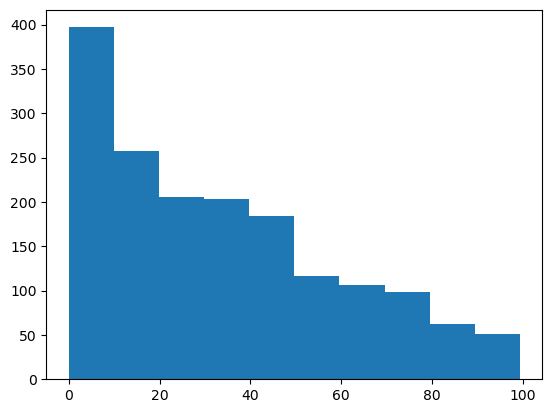

In [24]:
plt.hist(data['Inhibition'])

In [ ]:
args = ...
seed_everything(args.seed)

test['inhibition'] = 0.0
train, valid = train_test_split(data, test_size=0.2, random_state=args.seed)
train, valid = train.reset_index(drop=True), valid.reset_index(drop=True)

train_dataset = CustomDataset(df=train, mode='train')
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

valid_dataset = CustomDataset(df=valid, mode='test')
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False)

model = MedModel().to(device)
mse_loss = nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(), lr=5e-4)
ema = ExponentialMovingAverage(model.parameters(), decay=0.995)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=10, T_mult=1, verbose=False)
best_val_loss = 1e6

if not os.path.exists('./model_weights'):
    os.makedirs('./model_weights')

for epoch in range(45):
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(args.device)

        pred_inhibition = model(batch)
        targets = batch.y.to(args.device)

        loss = mse_loss(pred_inhibition, targets)

        optim.zero_grad()
        loss.backward()
        grad = clip_grad_norm_(model.parameters(), 1000)
        optim.step()
        ema.update()

        train_loss += loss.cpu().item()

    model.eval()
    valid_preds_inhibition, valid_label_inhibition = [], []

    for batch in valid_loader:
        batch = batch.to(args.device)
        with torch.no.grad():
            pred_inhibition = model(batch)
            targets = batch.y.to(args.device)

            valid_label_inhibition += targets.cpu.to_list()
            valid_preds_inhibition += pred_inhibition.cpu.to_list()

    inhibition_mse = mean_squared_error(valid_label_inhibition, valid_preds_inhibition)

    val_loss = inhibition_mse
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'./model_weights/model_{args.seed}_{args.fold}.pt')

    scheduler.step()
    print(f'EPOCH : {epoch} | train_loss : {train_loss/len(train_loader):.4f} | val_loss : {val_loss:.4f}')

### 학습 코드 뜯어보기

### 기본 학습 모듈

In [ ]:
model = MedModel().to(args.device)
mse_loss = nn.MSELoss()

optim = torch.optim.AdamW(model.parameters(), lr=5e-4)

ema = ExponentialMovingAverage(model.parameters(), decay=0.995)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim, T_0=10, T_mult=1, verbose=False)

- 모델: 사전학습에도 사용한 GNN에 fc layer를 추가
- 회귀이므로 mse loss 사용
- ema: 사전학습이 아니어도 ema는 사용하면 좋다 (decay가 0.995라는 것은 지수이동에서 parameter의 변화율을 0.995만큼 반영한다는 것)
- scheduler
- WarmUp scheduler: 학습률을 줄였다가 늘리기를 반복하면서 모델을 warm up하는 방법
- CosineAnnealingWarmRestarts가 웬만한 task에서는 가장 잘 되지만 데이터가 노이즈가 심하거나 학습이 잘 안되는 경우는 WarmUp사용은 비추천

In [ ]:
loss = mse_loss(pred_inhibition, targets)

optim.zero_grad()
loss.backward()
grad = clip_grad_norm_(model.parameters(), 1000)
optim.step()
ema.update()

- ema는 optimizer뒤에 위치시킴


### 오버피팅 방지

### nn.Linear weight값을 정규화
- 예측값이 회귀처럼 정교해야하는 경우에는 도움이 될 때가 가끔 있음

In [ ]:
self.fc[-1].weight.data.normal_(mean=0.0, std=0.01)

### Gradient Norm
- 계산한 Gradient를 clipping해주어서 일정 숫자가 넘지 않게 -> gradient exploding을 방지하여줌

In [ ]:
grad = clip_grad_norm_(model.parameters(), 1000)

### 예측값 정규화
- 저해율 값은 0~100 사이 이므로 sigmoid함수로 정규화 시켜서 학습을 더 안정적으로 하여줌

In [ ]:
out = torch.sigmoid(self.fc(mol).squeeze(1)) * 100

### CrossValidation과 Seed앙상블

In [ ]:
for seed in [0, 1000, 2000, 1113, 2023]:
    ksplit = KFold(n_splits=5, shuffle=True, random_state=seed)

    for k, (train_idx, valid_idx) in enumerate(ksplit.split(data)):
        run()

        ...

- 대회에서는 다양한 모델의 앙상블 + 시드, Cross Validation앙상블이 필수
- 인공지능은 어떤 데이터를 학습하는지 그리고 random으로 정해지는 모델의 시작 weight값이 어떻게 되는지 등 사소한 영향을 많이 받음
- 따라서 여러 seed, 그리고 학습 데이터도 여러번 분할하여 모델을 여러개 생성하여 앙상블하는 것을 추천
- 대회가 아닌 연구라면 여러번 반복해서 구한 성능의 신뢰구간을 제시해야하기도 함